Notebook containing Analysis for positron anihillation experiment

In [1]:
import compton.Dataloader as dl
from compton.Functions import *
from compton.Analysis import *
from positron.Dataloader import *
from positron.Analysis import *
import os
from sympy import symbols, Eq, latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd


First step is to make a fit for energies to rescale the energy readings from the osprey. We will do this by fitting the known values of each peak vs the experimental values, to obtain a function that brings us from known value up to actual value. 

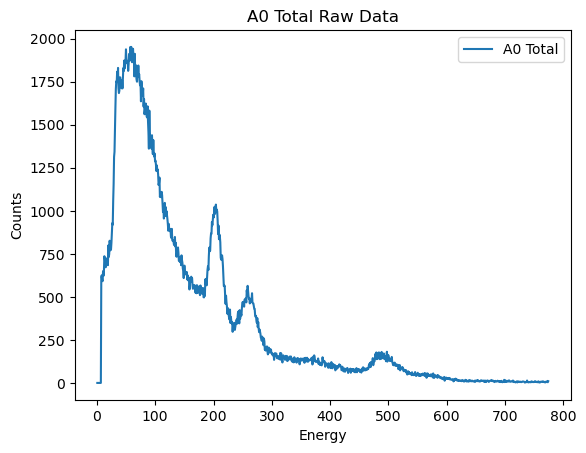

In [2]:
base_path = "../Databases/Positron/"

A0Total = load_gamma_count(base_path + "A0Total.csv")# 60 minute run?
plot_raw(A0Total, "0 Total")

Angle not int, defaulting to 0


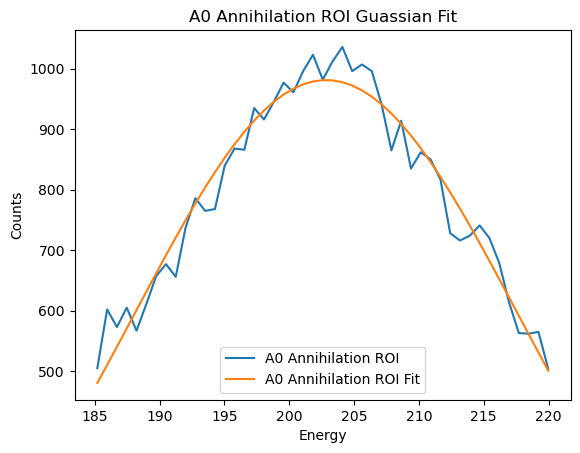

Angle not int, defaulting to 0


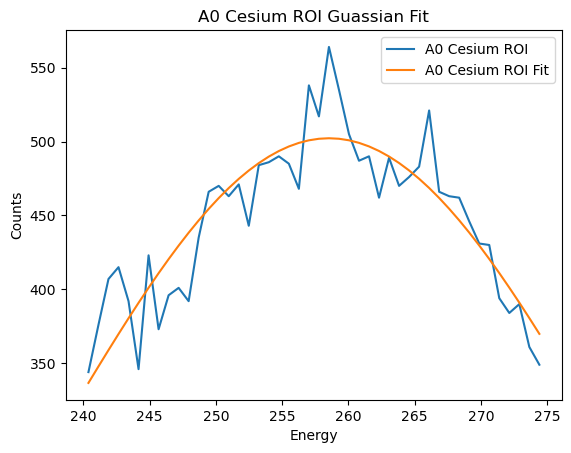

Angle not int, defaulting to 0


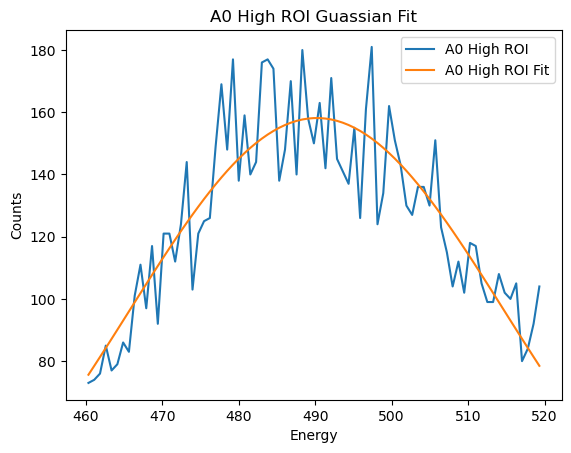

,Mean,Sigma,Unc Mean,Unc Sigma
ROI,,,,
Annihilation,202.847230,-14.770341,0.166889,0.265752
Cesium,258.528880,20.291170,0.390424,0.852191
High,490.217417,24.585945,0.519993,0.820401


In [3]:
#define 3 ROIs, that we will fit guassians to


annihilation_roi = trim_df(A0Total, 185, 220)
plot_guassian_fit(annihilation_roi, angle = "0 Annihilation ROI")

cesium_roi = trim_df(A0Total, 240, 275)
plot_guassian_fit(cesium_roi, angle = "0 Cesium ROI")

high_roi = trim_df(A0Total, 460, 520)
plot_guassian_fit(high_roi, angle = "0 High ROI", p0_overide=[175,490,20,])

ROIs = {"Annihilation": annihilation_roi, "Cesium": cesium_roi, "High": high_roi}
peaks = run_all_peak_fits(ROIs)
display(peaks)

In [4]:
dfs = load_positron_angles("../Databases/Positron/") #dfs is a dictionary, not a list
print(dfs.keys())
print(dfs[0].head())
dfs = {angle: trim_df(df, 0, 300) for angle, df in dfs.items()}



dict_keys([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
   Channel  Energy (keV)  Counts
0        1      0.755920       0
1        2      1.511840       0
2        3      2.267760       0
3        4      3.023679       0
4        5      3.779599       0


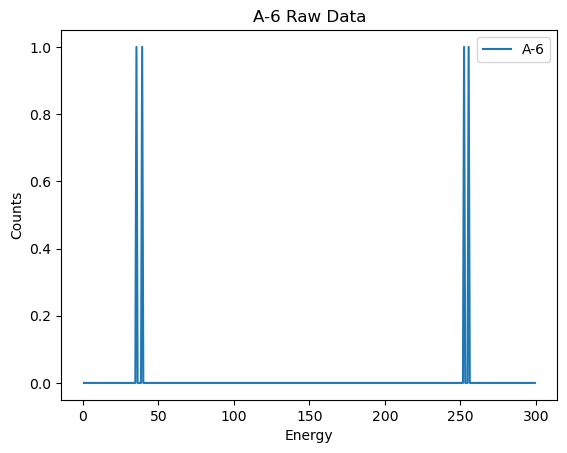

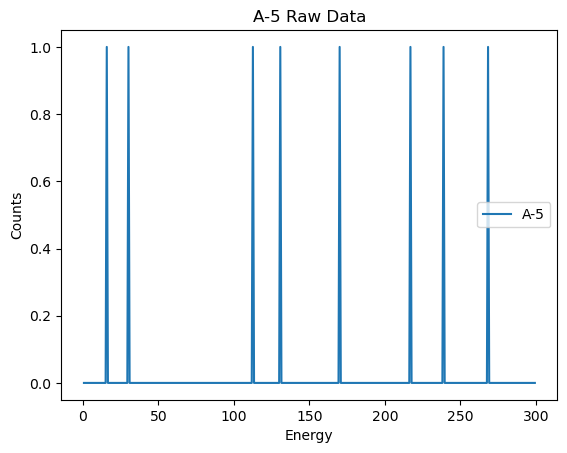

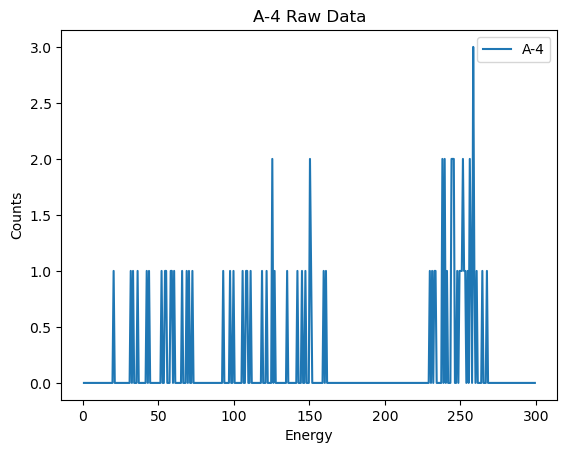

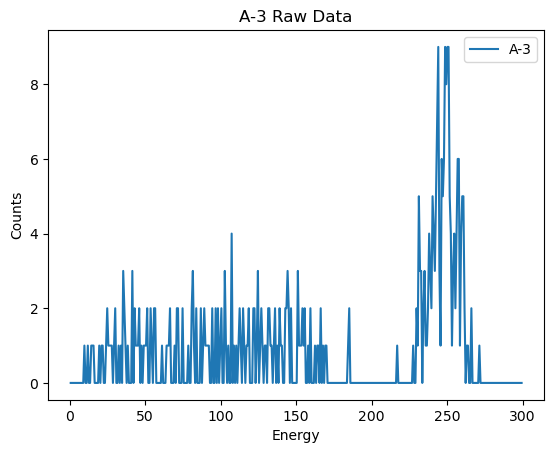

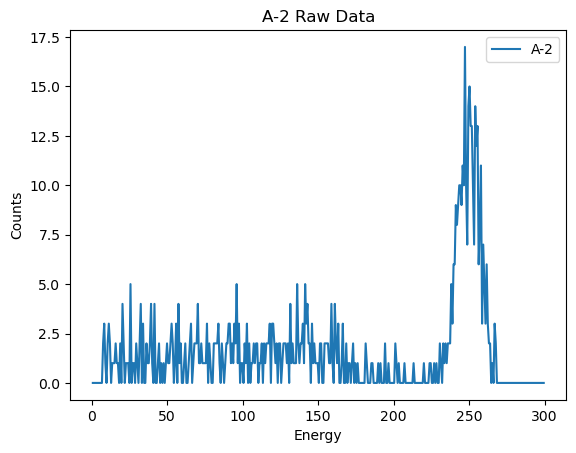

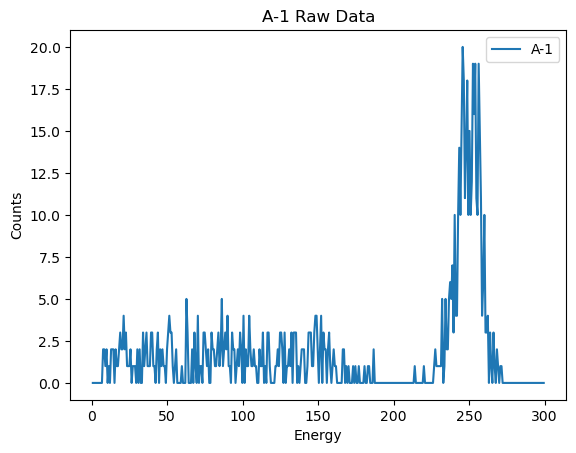

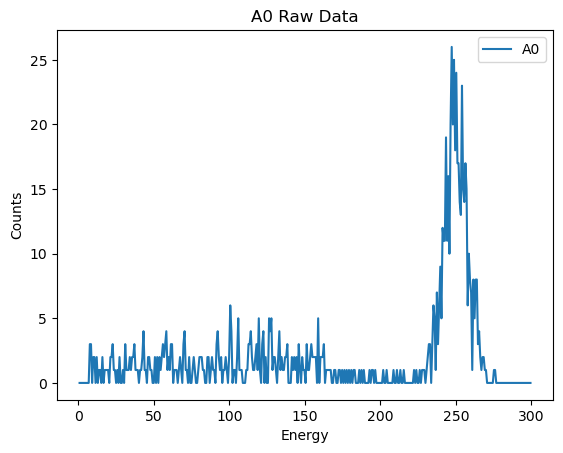

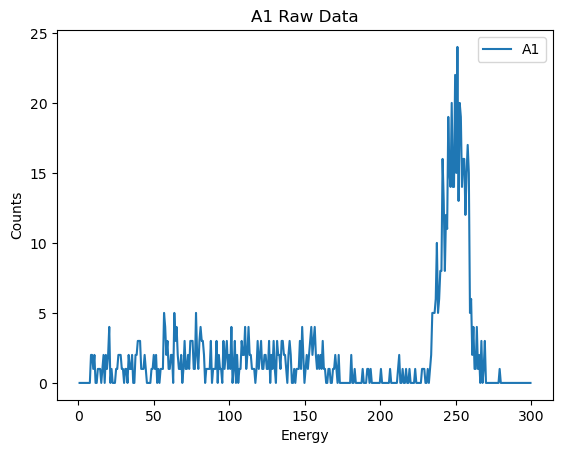

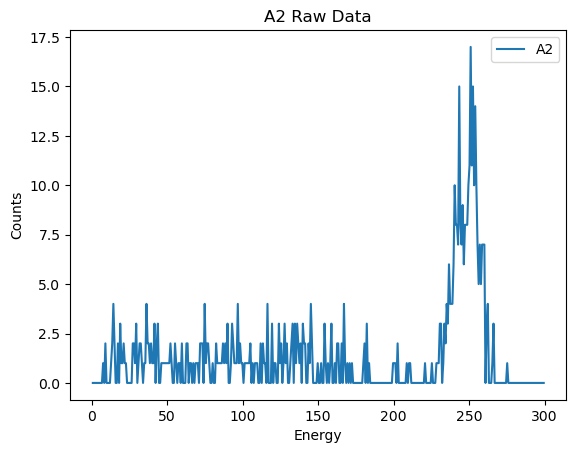

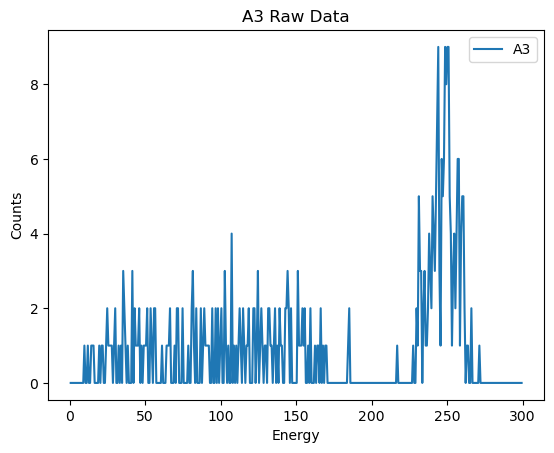

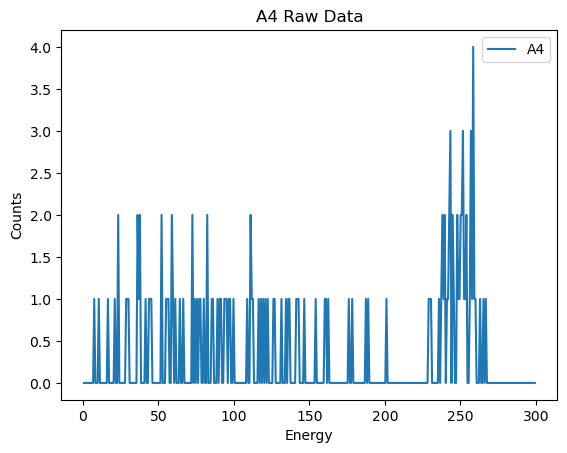

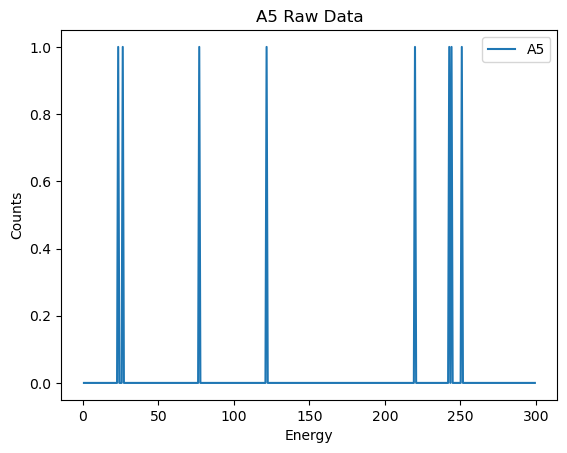

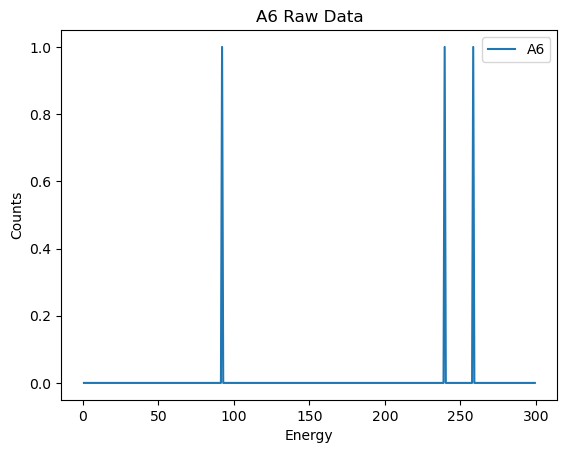

In [5]:
for angle, df in dfs.items():
    plot_raw(df, angle)

839


,Counts,Error,normalized_counts,normalized_error
Angle,,,,
-6,4,2.000000,0.004768,0.002384
-5,8,2.828427,0.009535,0.003371
-4,71,8.426150,0.084625,0.010043
-3,356,18.867962,0.424315,0.022489
-2,663,25.748786,0.790226,0.030690
-1,731,27.037012,0.871275,0.032225
0,839,28.965497,1.000000,0.034524
1,821,28.653098,0.978546,0.034151
2,558,23.622024,0.665077,0.028155


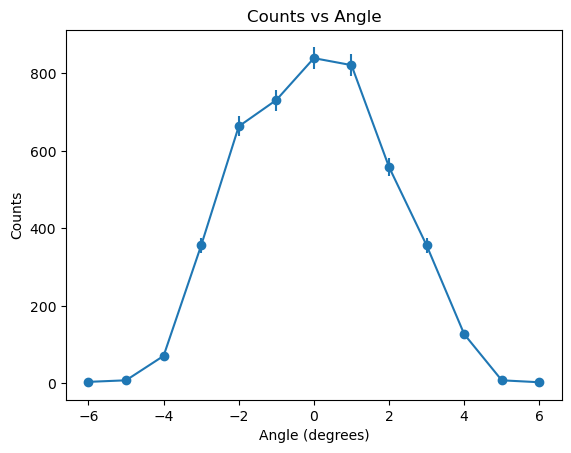

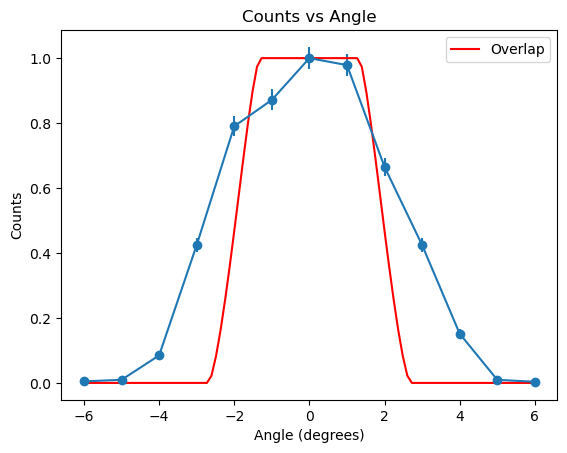

In [6]:
counts = total_counts(dfs)
display(counts)
plot_counts(counts)
plot_counts(counts, Normalized=True, overlap=True)

Part 2: time window analysis

The next step is to identify counts for specific ROIs on the 15 degree angle accidental coincidence rate

first step: obtain dataframes with counts for the 15 degree angle by ROI. should be 2 rows, one for each ROI. 
columns should be the counts per second for osprey 1, counts per second for osprey 2, and accidental coincidence counts per second

big problem: where is 1274 kev peak?!!!

I think we have to rescale the energies. not clear exactly how to do this.

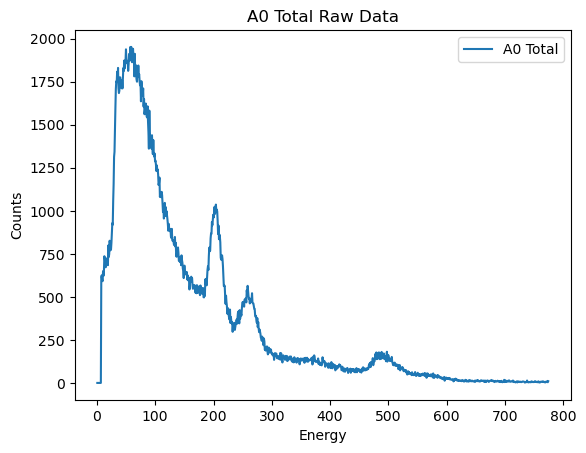

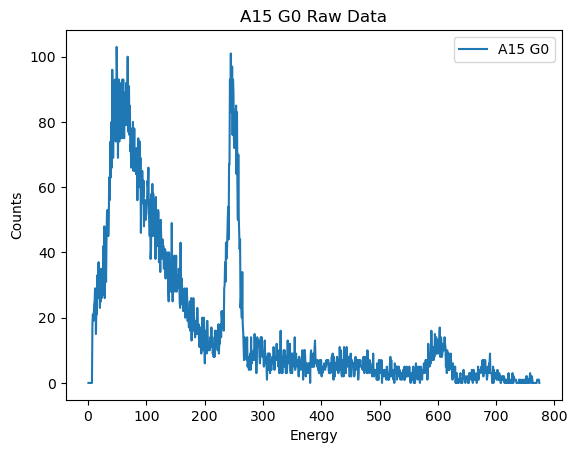

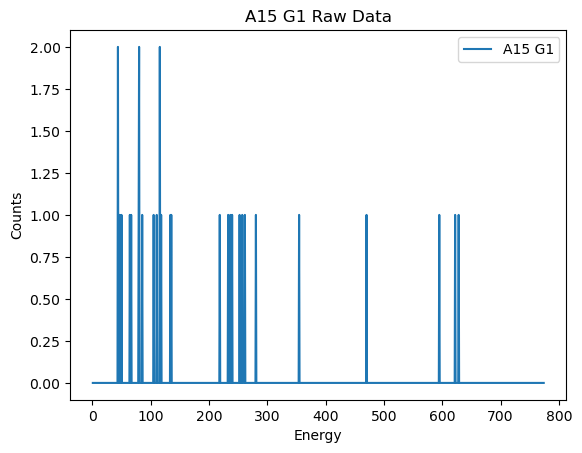

In [7]:
base_path = "../Databases/Positron/"

A0Total = load_gamma_count(base_path + "A0Total.csv")# 60 minute run?
plot_raw(A0Total, "0 Total")
A15G0 = load_gamma_count(base_path + "A15G0.csv") #g2 means coinicidence turned off "ungated". note: 20 minute run!
plot_raw(A15G0, "15 G0")
A15G1 = load_gamma_count(base_path + "A15G1.csv") #G1 means coincidence turned on. "gated" note: 20 minute run!!
plot_raw(A15G1, "15 G1")